In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder_path = '/content/drive/My Drive/ml31009_finalproject/'

In [ ]:
#from Parquet

storm_data_df = pd.read_parquet(folder_path + 'storm_data_df.parquet')
print("storm_data_df loaded successfully")

storm_data_df loaded successfully


In [ ]:
#'datetime' is in datetime format
storm_data_df['datetime'] = pd.to_datetime(storm_data_df['datetime'])

#filter dataset to only include records from 1970 or later
storm_data_df = storm_data_df[storm_data_df['datetime'].dt.year >= 1967].copy()

#extra temporal features
storm_data_df['year'] = storm_data_df['datetime'].dt.year
storm_data_df['month'] = storm_data_df['datetime'].dt.month
storm_data_df['day'] = storm_data_df['datetime'].dt.day
storm_data_df['hour'] = storm_data_df['datetime'].dt.hour

#preview the new features
print(storm_data_df[['datetime', 'year', 'month', 'day', 'hour']].head())

                datetime  year  month  day  hour
2740 1967-06-10 12:00:00  1967      6   10    12
2741 1967-06-10 18:00:00  1967      6   10    18
2742 1967-06-11 00:00:00  1967      6   11     0
2743 1967-06-11 06:00:00  1967      6   11     6
2744 1967-06-11 12:00:00  1967      6   11    12


In [ ]:
#def input features
input_features = [
    'duration_hours', 'trajectory_distance_km',
    'x', 'y', 'z', 'U', 'V', 'DVMX',
    'min_pressure', 'max_wind_speed', 'delta_wind',
    'year', 'month', 'day', 'hour',
    'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4',
    'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9',
    'cluster_10', 'cluster_11', 'cluster_12', 'cluster_13', 'cluster_14'
]

In [ ]:
#normalize all input features
scaler = MinMaxScaler()
storm_data_df[input_features] = scaler.fit_transform(storm_data_df[input_features])

In [ ]:
print("NaN values per column:\n", storm_data_df[input_features].isna().sum())

NaN values per column:
 duration_hours            0
trajectory_distance_km    0
x                         0
y                         0
z                         0
U                         0
V                         0
DVMX                      0
min_pressure              0
max_wind_speed            0
delta_wind                0
year                      0
month                     0
day                       0
hour                      0
cluster_0                 0
cluster_1                 0
cluster_2                 0
cluster_3                 0
cluster_4                 0
cluster_5                 0
cluster_6                 0
cluster_7                 0
cluster_8                 0
cluster_9                 0
cluster_10                0
cluster_11                0
cluster_12                0
cluster_13                0
cluster_14                0
dtype: int64


In [ ]:
#Inf or -Inf values
print("Inf values per column:\n", np.isinf(storm_data_df[input_features]).sum())

Inf values per column:
 duration_hours            0
trajectory_distance_km    0
x                         0
y                         0
z                         0
U                         0
V                         0
DVMX                      0
min_pressure              0
max_wind_speed            0
delta_wind                0
year                      0
month                     0
day                       0
hour                      0
cluster_0                 0
cluster_1                 0
cluster_2                 0
cluster_3                 0
cluster_4                 0
cluster_5                 0
cluster_6                 0
cluster_7                 0
cluster_8                 0
cluster_9                 0
cluster_10                0
cluster_11                0
cluster_12                0
cluster_13                0
cluster_14                0
dtype: int64


In [ ]:
#save scaler for inverse transformations later
#joblib.dump(scaler, 'lstm_scaler_wind_prediction_2.pkl')
joblib.dump(scaler, '/content/drive/My Drive/ml31009_finalproject/lstm_scaler_wind_prediction_2.pkl')


print(storm_data_df[input_features].head())

   duration_hours  trajectory_distance_km         x         y         z  \
0        0.091603                0.041754  0.374624  0.085769  0.399232   
1        0.091603                0.041754  0.369012  0.086433  0.399232   
2        0.091603                0.041754  0.363406  0.087174  0.399232   
3        0.091603                0.041754  0.358796  0.088509  0.401001   
4        0.091603                0.041754  0.356060  0.089600  0.402769   

          U         V      DVMX  min_pressure  max_wind_speed  ...  cluster_5  \
0  0.337919  0.340909  0.545977           0.0        0.451613  ...        0.0   
1  0.285796  0.340909  0.545977           0.0        0.451613  ...        0.0   
2  0.285796  0.340909  0.545977           0.0        0.451613  ...        0.0   
3  0.294523  0.352273  0.545977           0.0        0.451613  ...        0.0   
4  0.311906  0.352273  0.545977           0.0        0.451613  ...        0.0   

   cluster_6  cluster_7  cluster_8  cluster_9  cluster_10  clu

In [ ]:
print(storm_data_df[input_features].describe())

       duration_hours  trajectory_distance_km             x             y  \
count    26366.000000            26366.000000  26366.000000  26366.000000   
mean         0.317215                0.362393      0.654636      0.240838   
std          0.179139                0.218591      0.162610      0.169666   
min          0.000000                0.000000      0.000000      0.000000   
25%          0.172414                0.182049      0.524528      0.109519   
50%          0.293103                0.334650      0.662398      0.197029   
75%          0.439655                0.518179      0.782464      0.342018   
max          1.000000                1.000000      1.000000      1.000000   

                  z             U             V          DVMX  min_pressure  \
count  26366.000000  26366.000000  26366.000000  26366.000000  26366.000000   
mean       0.390462      0.329277      0.410366      0.548236      0.806580   
std        0.188944      0.105929      0.079234      0.056218      0.

In [ ]:
#number of timesteps for each sequence
n_timesteps = 8

def create_sequences(df, input_features, target_feature, n_timesteps):
    sequences = []
    targets = []

    #group data by storm_id
    for storm_id, group in df.groupby('storm_id'):
        #sort by time to ensure proper ordering
        group = group.sort_values('datetime')
        #extract input features and target variable
        data = group[input_features].values
        target = group[target_feature].values

        #create sequences
        for i in range(len(data) - n_timesteps):
            sequences.append(data[i:i + n_timesteps])  #seq of input features
            targets.append(target[i + n_timesteps])    #target value (next step)

    return np.array(sequences), np.array(targets)

#def the target feature
target_feature = 'max_wind_speed'

In [ ]:
#create sequences and targets
X, y = create_sequences(storm_data_df, input_features, target_feature, n_timesteps)

#shape of the resulting arrays
print(f"Shape of X (sequences): {X.shape}")
print(f"Shape of y (targets): {y.shape}")

Shape of X (sequences): (18819, 8, 30)
Shape of y (targets): (18819,)


In [ ]:
print("Sample sequence (X):", X[0])
print("Sample target (y):", y[0])

Sample sequence (X): [[0.06034483 0.01880881 0.47042722 0.03090847 0.20744106 0.33791892
  0.35294118 0.54597701 0.99110232 0.09677419 0.57065217 0.
  0.45454545 0.3        0.52173913 0.         0.         0.
  0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.06034483 0.01880881 0.47034523 0.03232874 0.21352814 0.33791892
  0.38823529 0.54597701 0.         0.09677419 0.57065217 0.
  0.45454545 0.3        0.7826087  0.         0.         0.
  0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.06034483 0.01880881 0.47026185 0.03377309 0.21960531 0.33791892
  0.38823529 0.54597701 0.99011369 0.09677419 0.57065217 0.
  0.45454545 0.33333333 0.         0.         0.         0.
  0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.06034483 0.01880881 0.46

In [ ]:
#sequentially split data into train/validation/test
n_samples = X.shape[0]

#def split ratios
train_ratio = 0.6  # 60% for training
val_ratio = 0.2    # 20% for validation
test_ratio = 0.2   # 20% for testing

#compute indices
train_end = int(n_samples * train_ratio)
val_end = int(n_samples * (train_ratio + val_ratio))

#perform sequential splits
X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

#convert data to float32
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')
y_test = y_test.astype('float32')

#check shapes
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (11291, 8, 30)
X_val shape: (3764, 8, 30)
X_test shape: (3764, 8, 30)
y_train shape: (11291,)
y_val shape: (3764,)
y_test shape: (3764,)


In [ ]:
#def the LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))  # Dropout for regularization
    model.add(LSTM(units=64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=1))  # Output layer (regression)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

#input shape: (n_timesteps, n_features)
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_lstm_model(input_shape)


model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 8, 64)               │          24,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,457 (232.25 KB)

 Trainable params: 59,457 (232.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#def early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0185 - mae: 0.1003 - val_loss: 0.0068 - val_mae: 0.0621
Epoch 2/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0062 - mae: 0.0581 - val_loss: 0.0039 - val_mae: 0.0488
Epoch 3/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0043 - mae: 0.0474 - val_loss: 0.0025 - val_mae: 0.0375
Epoch 4/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0031 - mae: 0.0394 - val_loss: 0.0025 - val_mae: 0.0370
Epoch 5/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0026 - mae: 0.0356 - val_loss: 0.0017 - val_mae: 0.0291
Epoch 6/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0022 - mae: 0.0322 - val_loss: 0.0014 - val_mae: 0.0257
Epoch 7/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0022 - mae: 0.0316 - val_loss: 0.0015 - val_mae: 0.0256
Epoch 8/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0021 - mae: 0.0307 - val_loss: 0.0014 - val_mae: 0.0248
Epoch 9/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - l

In [ ]:
#eval on the test set
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")


118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 - mae: 0.0240
Test Loss (MSE): 0.0018023771699517965
Test MAE: 0.024027539417147636


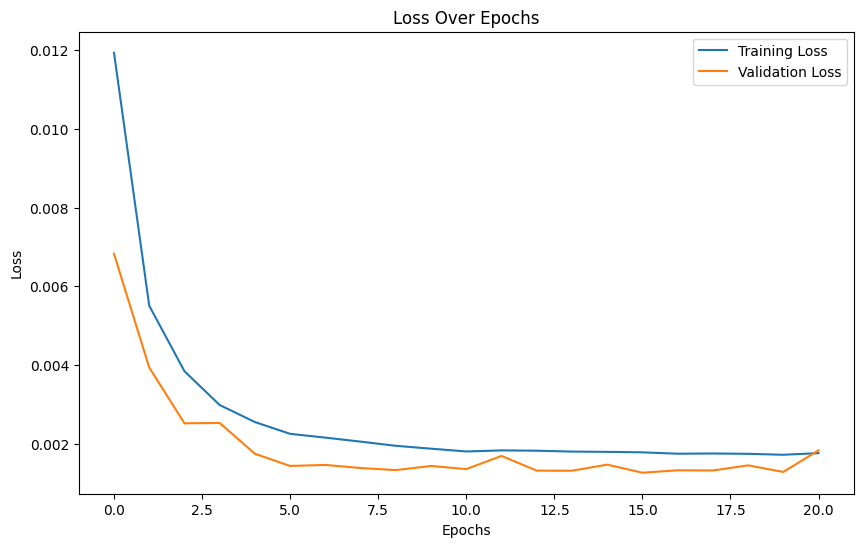

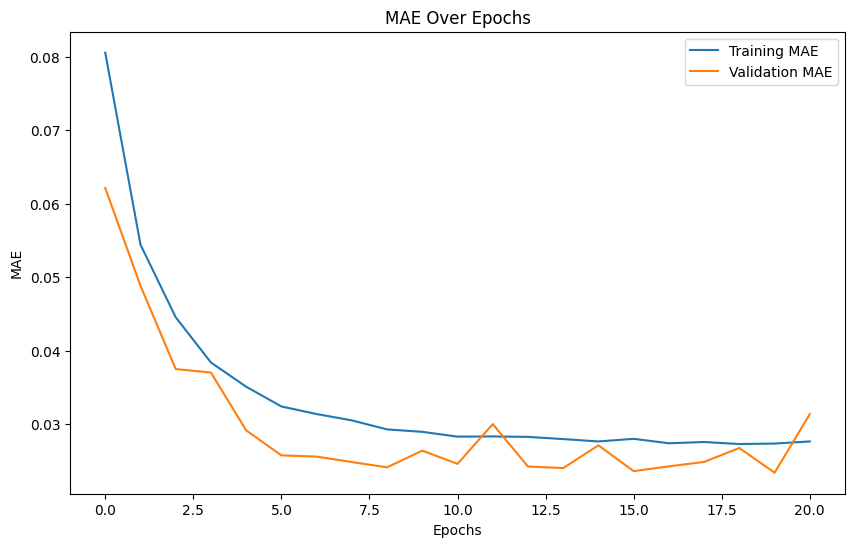

In [ ]:
#training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#training and validation MAE
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


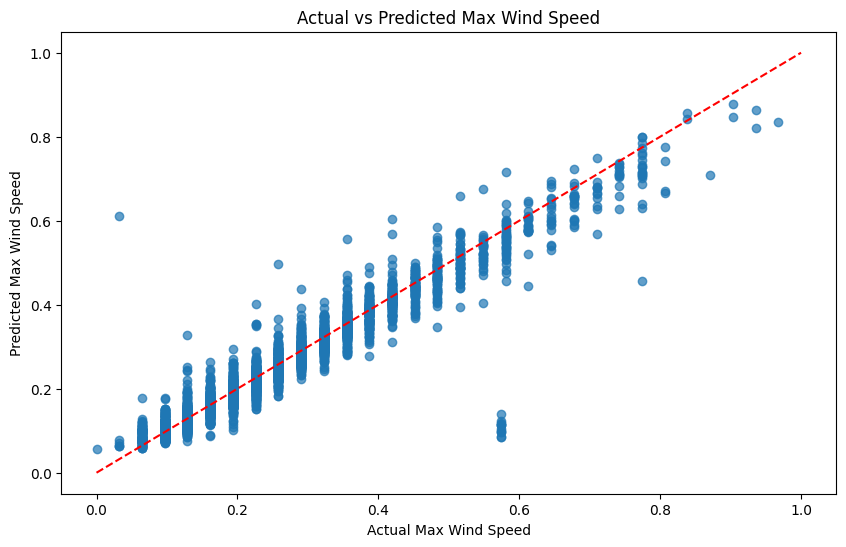

In [ ]:
#predictions on the test set
y_pred = model.predict(X_test)

#comp predictions with actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([0, 1], [0, 1], 'r--')  #perfect prediction (for scaled data)
plt.xlabel('Actual Max Wind Speed')
plt.ylabel('Predicted Max Wind Speed')
plt.title('Actual vs Predicted Max Wind Speed')
plt.show()

In [ ]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse}")

RMSE: 0.04245441406965256


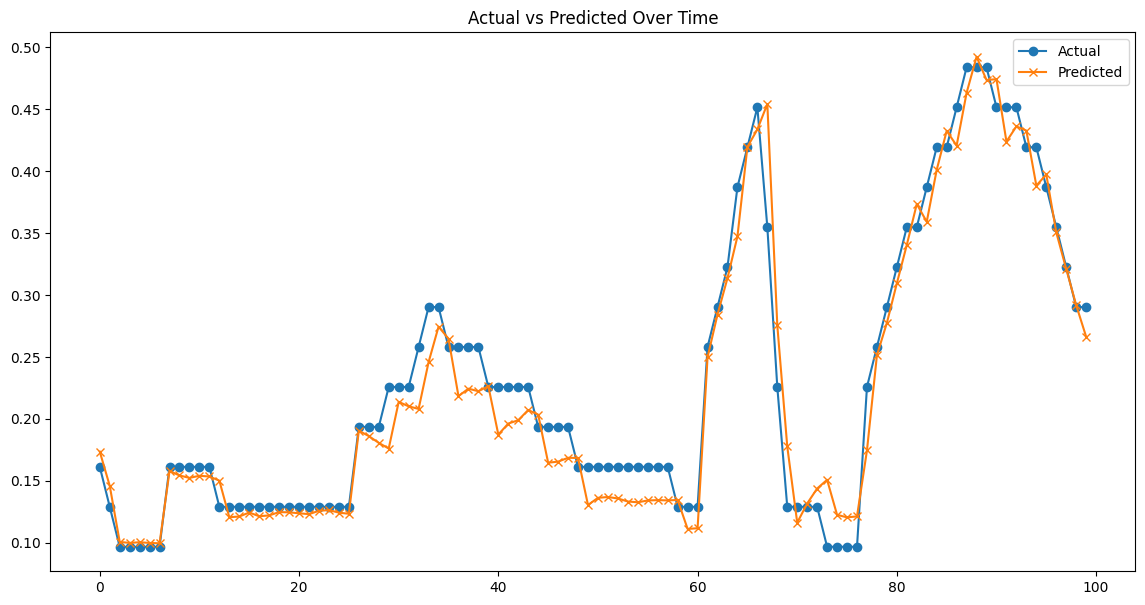

In [ ]:
#uses the first 100 predictions (y_test[:100] and y_pred[:100])
#y_test scaled vs. y_pred
#x axis ordered based upon sequence (time ordered)
plt.figure(figsize=(14, 7))
plt.plot(y_test[:100], label='Actual', marker='o')  #use a subset for clarity
plt.plot(y_pred[:100], label='Predicted', marker='x')
plt.legend()
plt.title('Actual vs Predicted Over Time')
plt.show()

In [ ]:
#model.save('lstm_hurricane_model_windprediction_1.h5')
model.save('lstm_hurricane_model_wind_prediction_2.keras')

#model = tf.keras.models.load_model('lstm_hurricane_model_windprediction_1.h5')

#from tensorflow.keras.models import load_model

#model = load_model('lstm_hurricane_model_windprediction_1')

model.save('/content/drive/My Drive//ml31009_finalproject/lstm_hurricane_model_wind_prediction_2.keras')